<a href="https://colab.research.google.com/github/rezamohamadlo/ImageClassification/blob/main/Cifar_10ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os  # Operating system interactions
import re  # Regular expressions
import time  # Time-related functions
import json  # JSON data handling

# Import image processing libraries from PIL (Python Imaging Library)
import PIL.Image  # Image manipulation
import PIL.ImageFont  # Font handling for text in images
import PIL.ImageDraw  # Drawing shapes and text on images

# Import NumPy for numerical operations
import numpy as np

# Attempt to set TensorFlow version to 2.x if running in Google Colab
try:
    %tensorflow_version 2.x  # Set TensorFlow version in Colab
except Exception:
    pass  # Ignore error if not in Colab

# Import TensorFlow library
import tensorflow as tf

# Import the ResNet50 model from Keras applications for image classification
from tensorflow.keras.applications.resnet50 import ResNet50

# Import pyplot from matplotlib for plotting and visualization
from matplotlib import pyplot as plt

# Import TensorFlow Datasets for accessing common datasets easily
import tensorflow_datasets as tfds

# Print the current version of TensorFlow being used
print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.17.1


In [ ]:
# Define the batch size for training and evaluation
BATCH_SIZE = 32

# List of class labels for the dataset (CIFAR-10 classes)
classes = [
    'airplane',   # Class 0: Airplane
    'automobile',  # Class 1: Automobile
    'bird',       # Class 2: Bird
    'cat',        # Class 3: Cat
    'deer',       # Class 4: Deer
    'dog',        # Class 5: Dog
    'frog',       # Class 6: Frog
    'horse',      # Class 7: Horse
    'ship',       # Class 8: Ship
    'truck'       # Class 9: Truck
]

In [ ]:
#@title Visualization Utilities[RUN ME]

# Matplotlib configuration settings
plt.rc('image', cmap='gray')  # Set default colormap to gray for images
plt.rc('grid', linewidth=0)  # Disable grid lines
plt.rc('xtick', top=False, bottom=False, labelsize='large')  # Configure x-axis ticks
plt.rc('ytick', left=False, right=False, labelsize='large')  # Configure y-axis ticks
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')  # Set axes properties
plt.rc('text', color='a8151a')  # Set text color for plots
plt.rc('figure', facecolor='F0F0F0')  # Set figure background color

# Define the directory for Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# Utility function to display a row of images with their predictions
def display_images(digits, predictions, labels, title):
    n = 10  # Number of images to display

    # Randomly select indices to display from the predictions array
    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]  # Selected images
    n_predictions = predictions[indexes].reshape((n,))  # Reshape predictions for display
    n_labels = labels[indexes]  # Corresponding true labels

    # Create a figure to display the images
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)  # Set the title of the figure
    plt.yticks([])  # Hide y-ticks
    plt.xticks([])  # Hide x-ticks

    # Loop through each selected image and display it with its predicted label
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1)  # Create a subplot for each image
        class_index = n_predictions[i]  # Get the predicted class index

        plt.xlabel(classes[class_index])  # Label the image with its predicted class name
        plt.xticks([])  # Hide x-ticks for individual images
        plt.yticks([])  # Hide y-ticks for individual images
        plt.imshow(n_digits[i])  # Display the image

# Utility function to plot training and validation metrics over epochs
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)  # Set the title of the plot
    plt.ylim(0, ylim)  # Set y-axis limits
    plt.plot(history.history[metric_name], color='blue', label=metric_name)  # Plot training metric
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)  # Plot validation metric

In [ ]:
(training_images, training_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


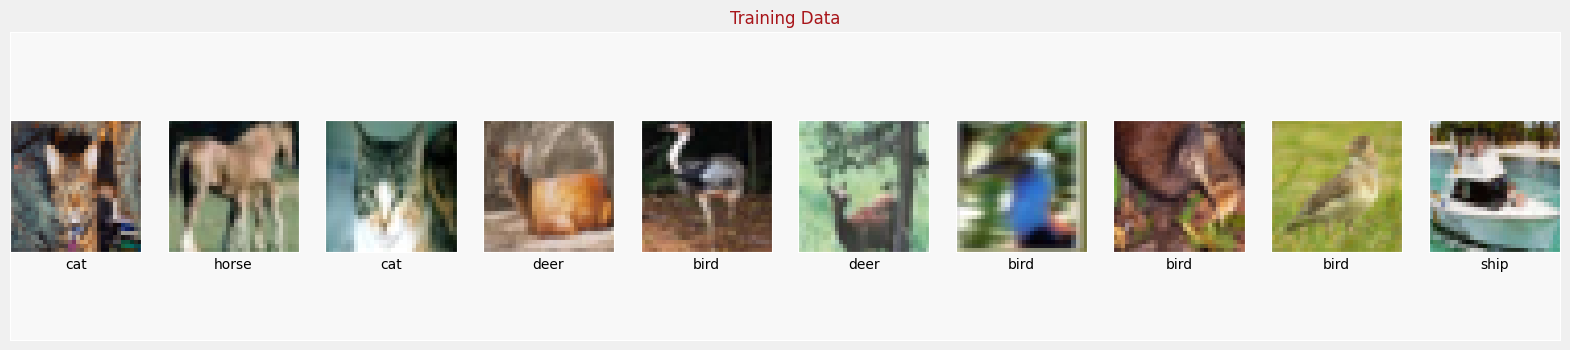

In [ ]:
# Display a selection of training images along with their corresponding labels
display_images(training_images, training_labels, training_labels, "Training Data")

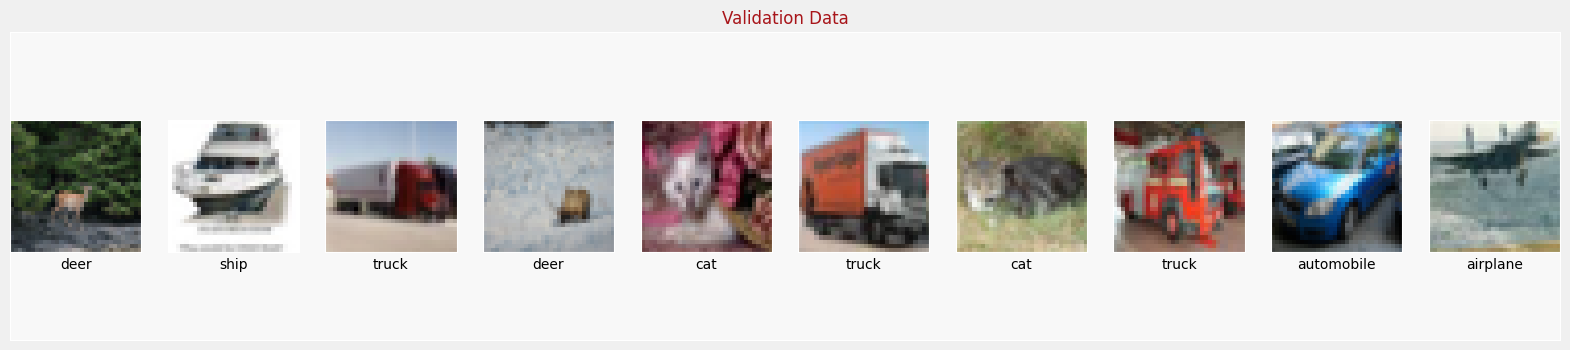

In [ ]:
# Display a selection of validation images along with their corresponding labels
display_images(validation_images, validation_labels, validation_labels, "Validation Data")

In [ ]:
# Get the shape of the first validation image after converting its data type to float32
image_shape = validation_images[0].astype('float32').shape

# Display the shape of the first validation image
print(image_shape)

(32, 32, 3)


In [ ]:
def preprocess_image_input(input_images):
    """
    Preprocesses input images for use with the ResNet50 model.

    Parameters:
    input_images (numpy.ndarray): Array of images to be preprocessed.

    Returns:
    numpy.ndarray: Preprocessed images ready for model input.
    """

    # Convert the image data type to float32 for compatibility with TensorFlow
    input_images = input_images.astype('float32')

    # Preprocess the images using ResNet50's specific preprocessing function
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)

    return output_ims  # Return the preprocessed images

In [ ]:
# Preprocess the training images for input into the ResNet50 model
train_X = preprocess_image_input(training_images)

# Preprocess the validation images for input into the ResNet50 model
valid_X = preprocess_image_input(validation_images)

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on ImageNet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs):
    """
    Creates a feature extractor using the ResNet50 model.

    Parameters:
    inputs (tensor): Input tensor for the model.

    Returns:
    tensor: Output tensor after feature extraction.
    """
    # Load the ResNet50 model without the top classification layer, using ImageNet weights
    feature_extractor = tf.keras.applications.resnet.ResNet50(
        input_shape=(224, 224, 3),  # Input shape for ResNet50
        include_top=False,           # Exclude the fully connected layers at the top
        weights='imagenet'          # Use pretrained weights from ImageNet
    )(inputs)  # Apply the model to the input tensor

    return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    """
    Creates a classifier model consisting of dense layers.

    Parameters:
    inputs (tensor): Input tensor from the feature extractor.

    Returns:
    tensor: Output tensor after classification.
    """
    # Global average pooling to reduce the spatial dimensions
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)

    # Flatten the pooled output to feed into dense layers
    x = tf.keras.layers.Flatten()(x)

    # First dense layer with ReLU activation
    x = tf.keras.layers.Dense(1024, activation="relu")(x)

    # Second dense layer with ReLU activation
    x = tf.keras.layers.Dense(512, activation="relu")(x)

    # Output layer with softmax activation for multi-class classification (10 classes)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

    return x


'''
Since input image size is (32 x 32), first upsample the image by a factor of (7x7) to transform it to (224 x 224).
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):
    """
    Builds the final model by upsampling input images and connecting feature extractor and classifier.

    Parameters:
    inputs (tensor): Input tensor of shape (32, 32, 3).

    Returns:
    tensor: Output tensor after classification.
    """

    # Upsample the input image from (32, 32) to (224, 224)
    resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)

    # Extract features from the upsampled image
    resnet_feature_extractor = feature_extractor(resize)

    # Classify the extracted features
    classification_output = classifier(resnet_feature_extractor)

    return classification_output


'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical Crossentropy as the loss function.
'''
def define_compile_model():
    """
    Defines and compiles the complete model.

    Returns:
    model: Compiled Keras model ready for training.
    """

    # Define input shape for images of size (32, 32, 3)
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    # Build the final model architecture
    classification_output = final_model(inputs)

    # Create a Keras Model instance
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    # Compile the model with SGD optimizer and sparse categorical crossentropy loss
    model.compile(optimizer='SGD',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


# Instantiate and compile the model
model = define_compile_model()

# Print a summary of the model architecture
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Set the number of epochs for training the model
EPOCHS = 4  # This will take around 20 minutes to complete

# Train the model using the training data and validate using validation data
history = model.fit(
    train_X,  # Preprocessed training images
    training_labels,  # Corresponding labels for training images
    epochs=EPOCHS,  # Number of epochs to train the model
    validation_data=(valid_X, validation_labels),  # Validation data and labels
    batch_size=64  # Number of samples per gradient update
)

Epoch 1/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 503s 589ms/step - accuracy: 0.7744 - loss: 0.7113 - val_accuracy: 0.9325 - val_loss: 0.2015
Epoch 2/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 438s 545ms/step - accuracy: 0.9670 - loss: 0.1023 - val_accuracy: 0.9494 - val_loss: 0.1615
Epoch 3/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 460s 567ms/step - accuracy: 0.9899 - loss: 0.0358 - val_accuracy: 0.9511 - val_loss: 0.1625
Epoch 4/4
782/782 ━━━━━━━━━━━━━━━━━━━━ 502s 567ms/step - accuracy: 0.9964 - loss: 0.0153 - val_accuracy: 0.9443 - val_loss: 0.2013


In [ ]:
# Evaluate the model's performance on the validation dataset
loss, accuracy = model.evaluate(
    valid_X,  # Preprocessed validation images
    validation_labels,  # Corresponding labels for validation images
    batch_size=64  # Number of samples per evaluation step
)

# Print the evaluation results
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.9437 - loss: 0.1963
Validation Loss: 0.2013, Validation Accuracy: 0.9443


In [ ]:
# Plot the training and validation accuracy metrics over epochs
plot_metrics("accuracy", "Accuracy")

157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step


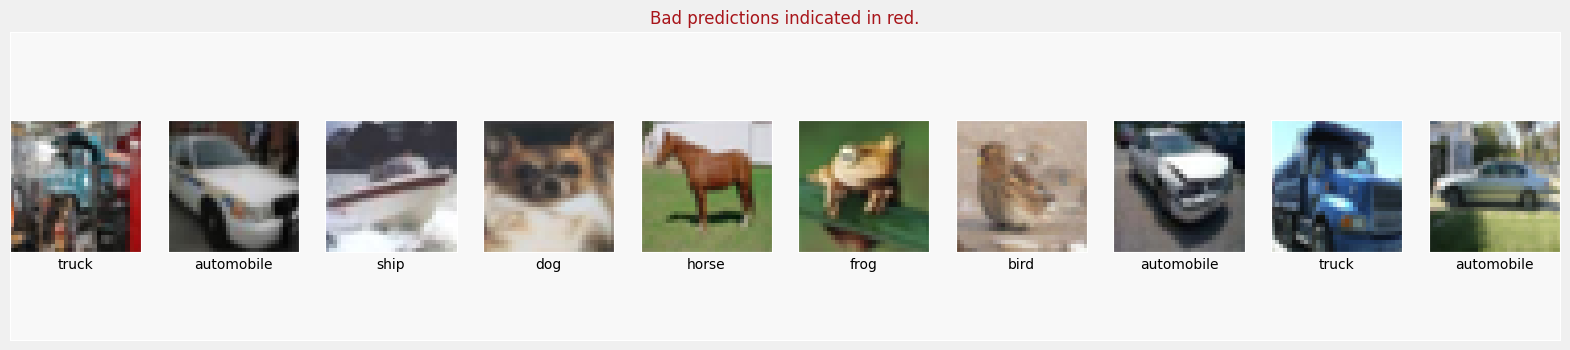

In [ ]:
# Generate predictions for the validation dataset using the trained model
probabilities = model.predict(valid_X, batch_size=64)

# Convert the predicted probabilities to class labels by taking the index of the maximum probability
probabilities = np.argmax(probabilities, axis=1)

# Display validation images along with their predicted labels and true labels
# Bad predictions will be indicated in red
display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")